In [15]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import seaborn as sns

## <span style="green:green"> Analysis of BoardGameGeek Data from 2021 and Board Game Preferences of Players in my Personal Playgroup</span>
---
First, I found a dataset from BoardGameGeek.com that contained ~20,000 rows of data for board games from 2021 on Kaggle. That dataset can be found [here.](https://www.kaggle.com/datasets/andrewmvd/board-games)

Next, I created a Google Forms survey to gather information from my friends and family. The link to the Google Form can be found [here.](https://forms.gle/xJ2i4NNg1iaMEcCm6) It allowed me to simply collect a dataset of their top 5 board games of all time.

I then spent time cleaning the dataset I collected and added the BoardGameGeek.com ID to the dataset so that I could easily join on a unique identifier.

Then I created a SQLlite database file (the code for which can be found in the CreateSQLdb.ipynb file of this repository) using the cleaned .csv files of both the player dataset and the dataset from Kaggle. The dataset from Kaggle had to have a few interesting parameters since it was semicolon delimited and needed the decimal point notation to be changed from a comma to a decimal point.

Once I created the SQLlite database file I was able to consruct the below SQL query to join my two datasets on the BoardGameGeek.com ID and begin my analysis.

In [16]:
joined_games_query = ('''
SELECT fg.ID, fg."Player Name", bgg.Name, bgg."Year Published", bgg."Play Time", bgg."BGG Rank", bgg."Rating Average", bgg."Complexity Average", bgg.Mechanics, bgg.Domains, bgg.ID AS BGGID
FROM FavoriteGames AS fg
INNER JOIN bgg_dataset AS bgg ON fg.BGGID = bgg.ID;
''')                        

This next step creates my joined dataframe using the SQL query above and builds the favorite_games_by_player_df dataframe which I began to use to do my initial data analysis.

In [17]:
conn = sqlite3.connect('boardgame_data.db')
favorite_games_by_player_df = pd.read_sql_query(joined_games_query, conn)
favorite_games_by_player_df['Year Published'] = favorite_games_by_player_df['Year Published'].astype(int)
favorite_games_by_player_df['BGGID'] = favorite_games_by_player_df['BGGID'].astype(int)  
favorite_games_by_player_df['BGGID'] = favorite_games_by_player_df['BGGID'].astype(str) 
favorite_games_by_player_df.head()

,ID,Player Name,Name,Year Published,Play Time,BGG Rank,Rating Average,Complexity Average,Mechanics,Domains,BGGID
0,13,Ken G.,1817,2010,540,1523,8.75,4.68,"Auction/Bidding, Loans, Market, Network and Ro...",Strategy Games,63170
1,8,Eric M.,1861: The Railways of the Russian Empire,2006,360,2300,7.55,4.21,"Auction/Bidding, Network and Route Building, S...",Strategy Games,23817
2,3,Catherine G.,7 Wonders,2010,30,61,7.75,2.33,"Card Drafting, Drafting, Hand Management, Set ...","Family Games, Strategy Games",68448
3,4,Maurie B.,7 Wonders,2010,30,61,7.75,2.33,"Card Drafting, Drafting, Hand Management, Set ...","Family Games, Strategy Games",68448
4,16,Rex S.,The 7th Continent,2017,1000,34,8.15,2.87,"Cooperative Game, Grid Movement, Hand Manageme...",Thematic Games,180263


### Who likes the highest rated games?
My first data exploration was a simple one. BoardGameGeek.com, or BGG moving forward, allows players to rate board games they have played and then aggregates these ratings to create a Rating Average that appears on their website. Their philosophy for how these ratings are calculated can be found [here.](https://boardgamegeek.com/wiki/page/ratings)


In [18]:
rating_df = favorite_games_by_player_df.groupby('Player Name').aggregate({'Rating Average':'mean'})
rating_df = rating_df.sort_values(by='Rating Average', ascending=False).reset_index()


As we can see in the dataframe above, Joseph, Squire, and Brandon's favorite games seem to be the highest rated on BGG. 


Next, I wanted to create a visual that showed the breakdown of players and the average rating of their favorite games. Anecdotally, players who aren't as deep into the hobby and aren't as exposed to as many games tended to like games of lower rankings. Generally classic mass market games such as Clue, Monopoly, and Checkers.

Text(0.5, 1.0, 'Average Rating Per Player')

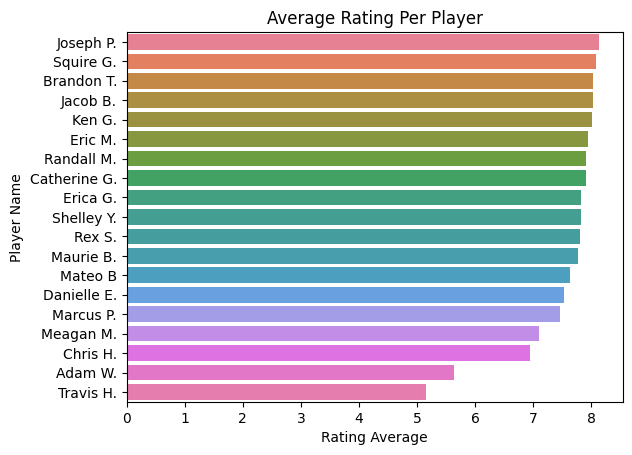

In [19]:
fig1 = sns.barplot(data=rating_df, x='Rating Average', y='Player Name', hue='Player Name')
plt.title("Average Rating Per Player")

### Who likes the "heaviest" games?
...
Next I wanted to explore "weight" among my playgroup. Who likes the "heaviest" or most difficult gaming experiences. BGG has a ranking for this as well that is voted on by users. Their philosophy for Game Play Weight rankings can also be found [here.](https://boardgamegeek.com/wiki/page/ratings)


In [20]:
complexity_df = favorite_games_by_player_df.groupby('Player Name').aggregate({'Complexity Average':'mean'})
complexity_df = complexity_df.sort_values(by='Complexity Average', ascending=False).reset_index()

As we can see on the table above, Ken, Eric, and Brandon lean towards games with a high complexity. Whereas, Meagan, Adam, and Travis prefer "lighter" less complex games.

Again, I created the visualization below to capture this dataset.

Text(0.5, 1.0, 'Complexity Rating Per Player')

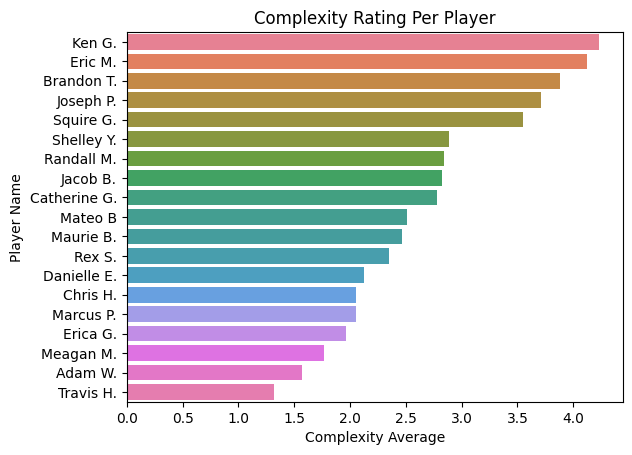

In [21]:
fig2 = sns.barplot(data=complexity_df, x='Complexity Average', y='Player Name', hue='Player Name',)
plt.title("Complexity Rating Per Player")

### What game is the most popular?

Next I wanted to create a dataset that showed which games occured most in people's top 5s. So the code below counts the number of mentions of a particular game in the favorite_games_by_player_df and informs us that the games mentioned most as a favorite game are Wingspan, Clue, and Ticket to Ride. The fact that the BGG dataset has over 20,000 games to choose form informs us on the popularity of these titles.

In [22]:
popular_game_df = favorite_games_by_player_df['Name'].value_counts().sort_values(ascending=False).reset_index(name="Counts")
total_top_5 = popular_game_df.head(5)
total_top_5


,Name,Counts
0,Wingspan,6
1,Clue,3
2,Ticket to Ride,3
3,Splendor,2
4,Brass: Lancashire,2


Next, I wanted to create a visualization that showed the overall top five games for our particular playgroup and what percentage each title has in the overall top 5. 

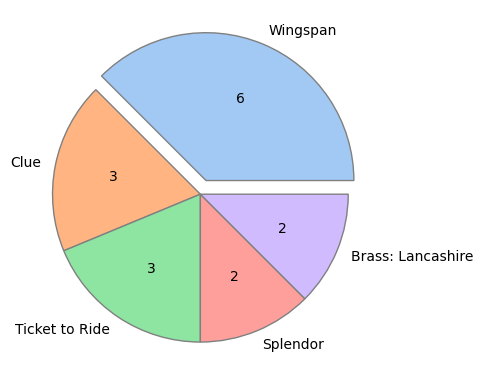

In [70]:
labels = total_top_5['Name']
data = total_top_5['Counts']
colors = sns.color_palette('pastel')[0:5]
explode = [0.1, 0, 0, 0, 0] 
autopct_format = lambda p: '{:.0f}'.format(p * sum(data) / 100)
plt.pie(data, labels=labels, colors=colors, explode=explode, autopct=autopct_format,
        wedgeprops = {"edgecolor" : "gray", 
                      'linewidth': 1, 
                      'antialiased': True})
plt.show()

### What are the newest and oldest games my playgroup likes?

Next I wanted to explore the newest and oldest games on our favorite games list. As we can see in the dataframe below, we enjoy several games that we published in 2020 (the board gaming hobby is often accused of having a 'cult of the new' mentality), but the oldest game on in the list is Go, dating back to 2200 BCE.

In [94]:
games_by_year_df = favorite_games_by_player_df.groupby('Name').aggregate({'Year Published':'min'}).reset_index()
games_by_year_df.sort_values(by='Year Published', ascending=False)

,Name,Year Published
66,Tidal Blades: Heroes of the Reef,2020
38,MicroMacro: Crime City,2020
40,My City,2020
42,On Mars,2020
11,Calico,2020
...,...,...
53,Sorry!,1929
21,Crokinole,1876
20,Cribbage,1630
15,Checkers,1150


Continuing this data exploration, I wanted to see what the oldest games each player liked. We can see in the dataframe below Jacob definitely likes the newest games of all the players. His oldest game being from 2016, and Brandon's favorite game Go, again, is the oldest game our group enjoys.

In [95]:
cult_of_the_new_df = favorite_games_by_player_df.groupby('Player Name').aggregate({'Year Published':'min'}).reset_index()
cult_of_the_new_df.sort_values(by='Year Published', ascending=False)

,Player Name,Year Published
7,Jacob B.,2016
16,Shelley Y.,2015
2,Catherine G.,2010
12,Maurie B.,2010
15,Rex S.,2008
11,Mateo B,2008
5,Eric M.,2005
17,Squire G.,2005
9,Ken G.,2004
3,Chris H.,2004


### What are our favorite mechanics?
After adding pivot(or junction) tables to the SQLlite database I was able to explore the game mechanics from the BGG dataset below. By using the pivot table to join on the mechanic ID I was able to build the dataframe below that showed the top 3 mechanics for each player based on their favorite games. Do they really like negotiation? or worker placement? or hidden roles? This table tells us their favorite mechanics! 

*Note: Because not all the games on the BGG dataset have mechanics identified, I dropped all the null selections from the dataframe in the SQL query.*

In [54]:
top3 = """SELECT *
FROM 
(SELECT fg."Player Name", m2.Value AS Mechanic, COUNT(*) AS Count,
RANK() OVER (PARTITION BY "Player Name" ORDER BY COUNT(*) DESC )AS RNK
FROM bgg_dataset bd
LEFT JOIN bgg_mechanic AS m ON bd.ID=m.bg_ID
LEFT JOIN mechanics m2 ON m.mechanic_ID=m2.ID
INNER JOIN FavoriteGames fg ON fg.BGGID=bd.ID
GROUP BY fg."Player Name", m2.Value) 
AS top_3
WHERE RNK <= 3 AND Mechanic IS NOT NULL"""

In [71]:
top_mechanics = pd.read_sql_query(top3, conn)
top_mechanics


,Player Name,Mechanic,Count,RNK
0,Adam W.,Turn Order: Random,2,2
1,Adam W.,Selection Order Bid,2,2
2,Brandon T.,Loans,3,2
3,Brandon T.,Kill Steal,3,2
4,Brandon T.,End Game Bonuses,3,2
...,...,...,...,...
87,Squire G.,Worker Placement,2,3
88,Squire G.,Variable Set-up,2,3
89,Squire G.,Turn Order: Progressive,2,3
90,Travis H.,Turn Order: Random,2,2


While the table above is great for looking at individual players and what they enjoy mechanic-wise. I was also curious what our favorite mechanics were as a playgroup! The table below shows the aggregate top 10 favorite mechanics for our playgroup!

In [63]:
favorite_mechanics_df=top_mechanics['Mechanic'].value_counts().sort_values(ascending=False).reset_index(name="Counts")
favorite_mechanics_df = favorite_mechanics_df.head(10)
favorite_mechanics_df

,Mechanic,Counts
0,Income,10
1,End Game Bonuses,7
2,Hand Management,7
3,Kill Steal,7
4,Drafting,6
5,Set Collection,6
6,Worker Placement,5
7,Solo / Solitaire Game,4
8,Turn Order: Progressive,3
9,Action/Event,3


I then thought it would be fun to visualize this particular dataframe using a pie chart. Evidently, we love our economic games, as *income* is our favorite mechanic. Before running this analysis I would have guessed *worker placement* would have been higher one our collective list.

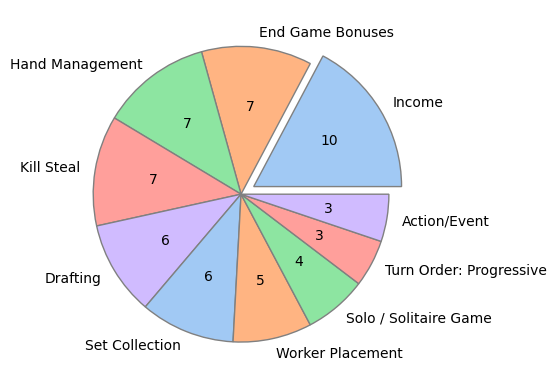

In [69]:
labels = favorite_mechanics_df['Mechanic']
data = favorite_mechanics_df['Counts']
colors = sns.color_palette('pastel')[0:5]
explode = [0.1,0,0,0,0,0,0,0,0,0]
autopct_format = lambda p: '{:.0f}'.format(p * sum(data) / 100)
plt.pie(data, labels=labels, colors=colors,explode=explode, autopct=autopct_format, 
        wedgeprops = {"edgecolor" : "gray", 
                      'linewidth': 1, 
                      'antialiased': True})
plt.show()

### What are our favorite game genres?

Lastly, I wanted to take a look at my playgroups favorite game genres. So much like the method above, I created the SQL query below to join on a pivot table created in the database from the *domain* column of the BGG dataset.

The results of this query are show in the table below it, showing the favorite genre of games for each player. Some players tied on their favorite genre -- so in these cases I just left both.

In [75]:
genre = """SELECT *
FROM 
(SELECT fg."Player Name", d2.Value AS Genre, COUNT(*) AS Count,
RANK() OVER (PARTITION BY "Player Name" ORDER BY COUNT(*) DESC )AS RNK
FROM bgg_dataset bd
LEFT JOIN bgg_domain AS bggd ON bd.ID=bggd.bg_ID
LEFT JOIN domains d2 ON bggd.domain_ID=d2.ID
INNER JOIN FavoriteGames fg ON fg.BGGID=bd.ID
GROUP BY fg."Player Name", d2.Value) 
WHERE RNK <= 1 AND "Domain" IS NOT NULL """

In [76]:
top_genre = pd.read_sql_query(genre, conn)
top_genre

,Player Name,Genre,Count,RNK
0,Adam W.,Family Games,2,1
1,Adam W.,Abstract Games,2,1
2,Brandon T.,Strategy Games,4,1
3,Catherine G.,Strategy Games,5,1
4,Chris H.,Strategy Games,2,1
5,Chris H.,Family Games,2,1
6,Danielle E.,Family Games,4,1
7,Eric M.,Strategy Games,5,1
8,Erica G.,Family Games,3,1
9,Jacob B.,Strategy Games,4,1


Then I of course wanted to see what our favorite genres were as a playgroup, and overwhelmingly so we like Strategy games. No surprise there. 

In [89]:
favorite_genre_df=top_genre['Genre'].value_counts().sort_values(ascending=False).reset_index(name="Counts")
favorite_genre_df = favorite_genre_df.head(4)
favorite_genre_df

,Genre,Counts
0,Strategy Games,13
1,Family Games,8
2,Abstract Games,1
3,Thematic Games,1


And finally, I went back to a bar chart for this one, but I wanted a simple visualization to capture my playgroup's favorite genre!

Text(0.5, 1.0, 'Favorite Genres')

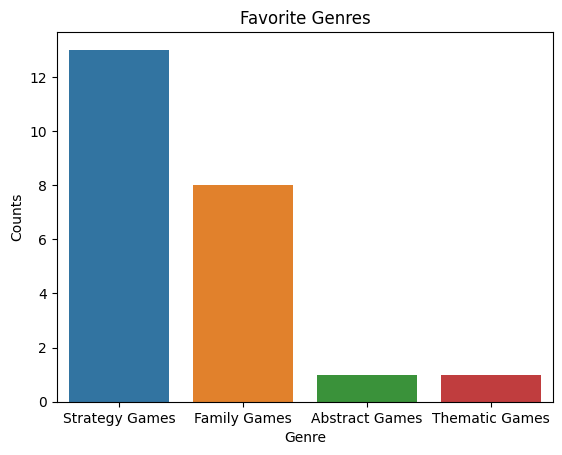

In [91]:
fig5 = sns.barplot(data=favorite_genre_df, x='Genre', y='Counts', hue='Genre')
plt.title("Favorite Genres")